In [352]:
import pandas as pd
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [208]:
def rmse(pred, y):
    n = len(y)
    RMSE = np.sqrt(sum((pred - y)**2) / n)
    return RMSE

In [910]:
data_wdate = pd.read_csv('../reduced_wdate.csv', index_col=0)

In [911]:
data_wdate['ypa'] = data_wdate.airya+data_wdate.yaca
data_wdate.drop(columns=['airya','yaca','airyd','yac','psd','rushsd'], inplace=True)

In [912]:
dates = [[] for _ in range(3)]

In [913]:
for date in data_wdate.date:
    date = date.split('/')
    if date[1] == '01':
        date[1] == 13
        date[0] == int(date[0])-1
    for i in range(3):
        dates[i].append(int(date[i]))

In [914]:
dates = pd.DataFrame(np.array(dates).T, columns=['yr','mon','day'], index=data_wdate.index)

In [915]:
data_wdate['mon'] = dates.mon + dates.day/31
data_wdate['yr'] = dates.yr
data_wdate.sort_values(['yr','mon'], inplace=True)

X_train = data_wdate[data_wdate.yr<=2014].drop(columns=['scores','date','ot'])
y_train = data_wdate[data_wdate.yr<=2014][['scores','team','yr']]
X_test = data_wdate[data_wdate.yr>2014].drop(columns=['scores','date','ot'])
y_test = data_wdate[data_wdate.yr>2014][['scores','team','yr']]

In [916]:
bag = BaggingRegressor(Lasso(), n_estimators=59, max_samples=.915)
bag.fit(X_train.drop(columns=['team','mon','yr']), y_train.scores)

BaggingRegressor(base_estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.915, n_estimators=59, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [917]:
teams = [(team, i) for i, team in enumerate(sorted(X_test.team.unique()))]
team_dict = dict(teams)

In [918]:
tm_clusterid = [[] for _ in range(3)]
for i in range(2009,2015):
    X_yr = X_train[X_train.yr==i]
    y_train_i = y_train.scores[X_train.yr==i]
    ses_season = [[] for _ in range(34)]
    for j in range(X_yr.shape[0]):
        X_gm = X_yr.iloc[j,:]
        X_gm = X_gm.drop(['team','mon','yr'], axis=0).copy()
        tm_gm_pred = bag.predict(X_gm.values.reshape(1, -1))
        se_gm = (tm_gm_pred-y_train_i.iloc[j])**2
        ses_season[team_dict[X_yr.team.iloc[j]]].append(se_gm)
    for k, tm in enumerate(ses_season):
        if len(tm)>0:
            tm_clusterid[0].append(teams[k][0])
            tm_clusterid[1].append(i)
            tm_clusterid[2].append(np.sqrt((sum(tm)/len(tm))).tolist()[0])

In [919]:
tm_clusterid = pd.DataFrame(tm_clusterid, index=['team','yr','rmse']).transpose()

In [943]:
n_clusters=2
kmeans = KMeans(n_clusters=n_clusters, random_state = 0).fit(tm_clusterid.rmse.values.reshape(-1,1))

In [944]:
tm_clusterid['clusterid'] = kmeans.labels_
tm_clusterid['yr'] = np.array(tm_clusterid.yr, dtype='int64')

In [945]:
lassos = []
for i in range(n_clusters):
    cluster_i = tm_clusterid[tm_clusterid.clusterid==i]
    X_i_train = cluster_i.merge(X_train, on=['team','yr'])
    X_i_train.drop(columns=['team','yr','mon','rmse','clusterid'], inplace=True)
    y_i_train = cluster_i.merge(y_train, on=['team','yr']).scores
    lasso_i = Lasso()
    lasso_i.fit(X_i_train, y_i_train)
    lassos.append(lasso_i)

In [946]:
y_pred_bag = []
y_pred_lassos = []
y_test_total = []
threshold=12
for i in range(2015,2018):
    X_yr = X_test[X_test.yr==i]
    y_test_i = y_test.scores[X_test.yr==i]
    ses_season = [[] for _ in range(34)]
    X_yr_early = X_yr[X_yr.mon<threshold]
    X_yr_late = X_yr[X_yr.mon>=threshold]
    y_test_early = y_test_i[X_yr.mon<threshold]
    y_test_late = y_test_i[X_yr.mon>=threshold]
    y_test_total.extend(y_test_late)
    for j in range(X_yr_early.shape[0]):
        X_gm = X_yr_early.iloc[j,:]
        X_gm = X_gm.drop(['team','mon','yr'], axis=0).copy()
        tm_gm_pred = bag.predict(X_gm.values.reshape(1, -1))
        se_gm = (tm_gm_pred-y_test_early.iloc[j])**2
        ses_season[team_dict[X_yr_early.team.iloc[j]]].append(se_gm)
    tm_clusterid_i = dict()
    for k, tm in enumerate(ses_season):
        if len(tm)>0:
            rmse_tm = np.sqrt((sum(tm)/len(tm))).tolist()[0]
            pred_cluster = kmeans.predict(np.array([rmse_tm]).reshape(1,-1))[0]
            tm_clusterid_i[teams[k][0]] = pred_cluster
    for j in range(X_yr_late.shape[0]):
        X_gm = X_yr_late.iloc[j,:]
        lasso_i = lassos[tm_clusterid_i[X_gm.team]]
        X_gm = X_gm.drop(['team','mon','yr'], axis=0).copy()
        
        tm_gm_pred = lasso_i.predict(X_gm.values.reshape(1, -1))
        y_pred_lassos.append(tm_gm_pred[0])
        
        tm_gm_bag = bag.predict(X_gm.values.reshape(1, -1))
        y_pred_bag.append(tm_gm_bag[0])

KeyError: 'Miami Dolphins'

In [951]:
X_yr_early.shape

(172, 16)

In [925]:
rmse(np.array(y_test_total), np.array(y_pred_lassos))

6.477784361959278

In [926]:
rmse(np.array(y_test_total), np.array(y_pred_bag))

6.430421982260228

Text(0.5, 1.0, 'Silhouette curve')

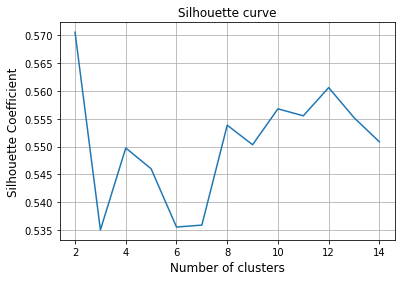

In [920]:
silhouettes = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state = 0)
    cluster_labels = kmeans.fit_predict(tm_clusterid.rmse.values.reshape(-1,1))
    silhouettes.append(silhouette_score(tm_clusterid.rmse.values.reshape(-1,1), cluster_labels))

# fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), silhouettes)
plt.grid(True)
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('Silhouette Coefficient', fontsize=12)
plt.title('Silhouette curve')

In [546]:
data = pd.read_csv('../reduced_noot.csv', index_col=0)
data['home'] = np.append(np.ones(int(data.shape[0]/2)), np.zeros(int(data.shape[0]/2)))

In [547]:
data.head()

,scores,predscores,tmhalfsc,opphalfsc,airya,yaca,psd,patt,comppct,ratt,rushsd,ypr,int_pct,sack_pct,sack_yd_pct,fum_pct,home
1,16,24.75,6,13,2.894737,3.842105,9.688538,19,0.578947,8,3.041381,1.500000,0.105263,0.095238,-0.523810,0.000000,1.0
2,38,24.75,10,7,4.280000,2.720000,5.771360,25,0.640000,13,2.466341,3.384615,0.000000,0.038462,-0.230769,0.025641,1.0
3,20,17.75,13,10,2.636364,1.636364,5.799367,11,0.636364,15,4.318436,3.466667,0.000000,0.153846,-0.769231,0.071429,1.0
4,7,24.75,0,10,1.333333,4.133333,5.473573,15,0.666667,10,4.044750,2.200000,0.000000,0.000000,0.000000,0.040000,1.0
5,14,25.50,7,6,4.047619,4.285714,9.140873,21,0.714286,15,3.234536,2.733333,0.047619,0.045455,-0.318182,0.027027,1.0


In [274]:
# X = data[['predscores','tmhalfsc','opphalfsc','airya','yaca','psd']]
X = data.drop(columns=['scores','date','team','ot')
y = data['scores']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [108]:
bag = BaggingRegressor(Lasso(), n_estimators=59, max_samples=.915)
bag.fit(X_train, y_train)

BaggingRegressor(base_estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.915, n_estimators=59, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [109]:
bag.score(X_test, y_test)

0.5427360335851822

In [110]:
rmse(bag.predict(X_test), y_test)

6.680319930120178

In [47]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [99]:
def plot_silhouette_curve(data, max_no_of_clusters = 15, Standardize = True):    
    X = data.drop(columns='scores')
    if Standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    silhouettes = []
    for k in range(2, max_no_of_clusters):
        kmeans = KMeans(n_clusters=k, random_state = 0)
        cluster_labels = kmeans.fit_predict(X)
        silhouettes.append(silhouette_score(X, cluster_labels))
        
    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(2, max_no_of_clusters), silhouettes)
    plt.grid(True)
    plt.xlabel('Number of clusters', fontsize=12)
    plt.ylabel('Silhouette Coefficient', fontsize=12)
    plt.title('Silhouette curve')

/Users/eddieowens/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/eddieowens/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


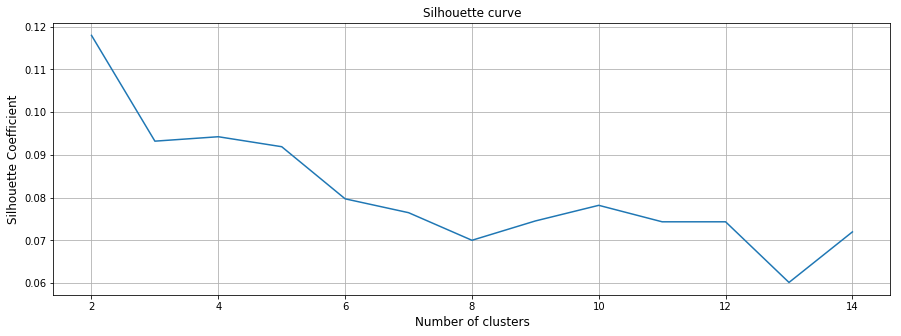

In [267]:
plot_silhouette_curve(data[data.home==0])

In [313]:
# separately cluster home and away
def cluster_home_away(n_clusters):
    X = data[data.home==1].drop(columns='scores')
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state = 0).fit(X)

    idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(n_clusters)

    X = data[data.home==0].drop(columns='scores')
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    kmeans2 = KMeans(n_clusters=n_clusters, random_state = 0).fit(X)

    idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
    lut2 = np.zeros_like(idx)
    lut2[idx] = np.arange(n_clusters)

    data['cluster_id'] = np.append(lut[kmeans.labels_], lut2[kmeans2.labels_]+n_clusters)

In [314]:
def cluster_normal(n_clusters):
    X = data.drop(columns='scores')
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state = 0).fit(X)

    idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(n_clusters)

    data['cluster_id'] = lut[kmeans.labels_]

In [189]:
def get_cluster_means(df):
    cluster_means = pd.DataFrame([], index=df.columns)
    for i in range(len(set(df.cluster_id))):
        means_feature_i = df[df.cluster_id==i].mean()
        means_feature_i = pd.DataFrame(means_feature_i, columns=[i])
        cluster_means = cluster_means.merge(means_feature_i, how='inner', left_index=True, right_index=True)
    cluster_means = cluster_means.transpose()
    cluster_means['count'] = df.cluster_id.value_counts()
    return cluster_means.drop('cluster_id', axis=1)

In [321]:
def fit_n_bags(n_clusters):
    y_pred = []
    y_actual = []
    scores = []
    for i in range(n_clusters):
        cluster_i = data[data.cluster_id==i]
        X = cluster_i.drop(columns=['cluster_id','scores','home'])
        y = cluster_i['scores']
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        bag = BaggingRegressor(Lasso(), n_estimators=59, max_samples=.9)
        bag.fit(X_train, y_train)

        y_pred_i = bag.predict(X_test)
        y_pred.extend(y_pred_i)
        y_actual.extend(y_test)
        scores.append((bag.score(X_test, y_test), rmse(y_test, y_pred_i)))
    
    y_pred = np.array(y_pred)
    y_actual = np.array(y_actual)
    
    return rmse(y_pred, y_actual), r2_score(y_actual, y_pred), scores

In [338]:
cluster_normal(1)
# cluster_home_away(1)

/Users/eddieowens/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/eddieowens/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [339]:
data.cluster_id.value_counts()

0    2938
Name: cluster_id, dtype: int64

In [340]:
get_cluster_means(data)

,scores,predscores,tmhalfsc,opphalfsc,airya,yaca,psd,patt,comppct,ratt,rushsd,ypr,int_pct,sack_pct,sack_yd_pct,fum_pct,home,count
0,22.334922,22.261572,11.179374,11.179374,3.848866,3.424165,8.74095,17.024506,0.627702,13.014295,5.117404,4.294557,0.025551,0.064862,-0.41521,0.018482,0.5,2938


In [342]:
n_clusters=1
results = []
score_avg = pd.DataFrame(np.zeros((n_clusters, 2)))
for i in range(50):
    rmse_i, r2, scores = fit_n_bags(n_clusters)
    score_avg += pd.DataFrame(scores)
    results.append((rmse_i, r2))

In [343]:
pd.DataFrame(results).mean()

0    6.775537
1    0.559747
dtype: float64

In [344]:
score_avg/50

,0,1
0,0.559747,6.775537


In [ ]:
6.775, .554

In [423]:
def fit_Random_Cactus(X, y, best_params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9213)
    base_rf = RandomForestRegressor(**best_params)
    base_rf.fit(X_train, y_train)
    base_rf_pred = base_rf.predict(X_test)
    base_rf_RMSE = rmse(base_rf_pred, y_test)
#     print(f"Decision Tree Regressor RMSE: {base_rf_RMSE:.3f}")
#     print(f"Random Forest Regressor R^2: {base_rf.score(X_test, y_test):.3f}")
    
    leaf_id_trees = base_rf.apply(X_train)
    regressors = dict()
    for i, leaves in enumerate(leaf_id_trees.transpose()):
        regressors_tree = dict()
        leaf_nodes = set(leaves)
        for leaf in leaf_nodes:
            leaf_sample_X = X_train[leaves==leaf]
            leaf_sample_y = y_train[leaves==leaf]
            leaf_regression = Lasso()
            leaf_regression.fit(leaf_sample_X, leaf_sample_y)
            regressors_tree[leaf] = leaf_regression
        regressors[i] = regressors_tree
    
    leaf_id_test_trees = base_rf.apply(X_test)
    y_pred = [[] for _ in range(leaf_id_test_trees.shape[0])]
    for i, leaves in enumerate(leaf_id_test_trees.transpose()):
        for j, leaf in enumerate(leaves):
            leaf_regression = regressors[i][leaf]
            pred_j = leaf_regression.predict(pd.DataFrame(X_test.iloc[j,:]).transpose())
            y_pred[j].append(pred_j[0])
    y_pred = [sum(row)/len(row) for row in y_pred]
        
#     print(f"Random Cactus RMSE: {rmse(y_pred, y_test):.3f}")
#     print(f"Random Cactus R^2: {r2_score(y_test, y_pred):.3f}")
        
    return y_pred

In [541]:
data = pd.read_csv('../reduced_noot.csv', index_col=0)
data['home'] = np.append(np.ones(int(data.shape[0]/2)), np.zeros(int(data.shape[0]/2)))
data['pya_psd'] = (data.airya+data.yaca)-data.psd
# data['rya_rsd'] = data.ypr/data.rushsd
# data = data.dropna()
X = data.drop(columns='scores')
y = data['scores']

In [542]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9213)

In [543]:
bag = BaggingRegressor(Lasso(), n_estimators=59, max_samples=.915)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)

In [544]:
# avg_coeffs = np.zeros(X.shape[1])
pd.DataFrame([bag.estimators_[i].coef_ for i in range(59)], columns=X.columns).mean()

predscores     0.520063
tmhalfsc       0.913906
opphalfsc      0.026614
airya          0.000000
yaca           0.000000
psd            0.001149
patt           0.013022
comppct        0.000000
ratt          -0.001425
rushsd         0.002634
ypr            0.000000
int_pct        0.000000
sack_pct       0.000000
sack_yd_pct    0.000000
fum_pct        0.000000
home           0.000000
pya_psd        0.000322
dtype: float64

In [545]:
r2_score(y_test, y_pred_bag)

0.5543201652271595

In [427]:
y_pred_rc = fit_Random_Cactus(X, y, {'min_samples_leaf': 0.011666666666666665, 'n_estimators': 95})

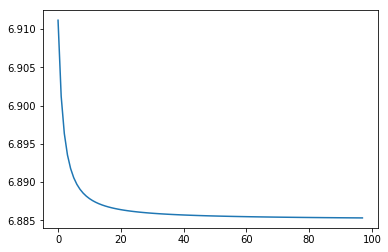

In [434]:
rmses = [rmse(y_test, (i*y_pred_bag+y_pred_rc)/(i+1)) for i in range(100)]
plt.plot(rmses[2:])
plt.show()

In [435]:
min_ind = rmses.index(min(rmses))
meta_ensemble = (min_ind*y_pred_bag+y_pred_rc)/(min_ind+1)

In [436]:
r2_score(y_test, meta_ensemble)

0.5541433502569222

In [437]:
rmse(y_test, meta_ensemble)

6.885294024681991

In [438]:
rmse(y_test, y_pred_bag)

6.885042826844175

In [439]:
min_ind

99